In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib import colormaps as cm
import gaitFunctions
import combineClips
import plotClip
import os
import glob
import seaborn as sns
from scipy import stats
import cv2

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [12]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_pair_color = '#a665c9'# violet
rear_pair_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.4
marker_color = 'k'

In [3]:
# load the step_timing data into a dataframe
excel_file = 'all_exemplaris_2024-07-29.xlsx'
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
step_df.head(3)

,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,anterior_offsets,contralateral_offsets,metachronal_lag,mcl_LR_ratio,L3_bearing_change,clip,treatment,individual,date,uniq_id
0,L1,0.575,1.030,0.455,0.182,0.637,0.7143,1.1210,L1:0.8571,R1:0.4286,...,NaN,0.394,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
1,L1,1.212,1.848,0.636,0.182,0.818,0.7775,1.9390,L1:0.8888,R1:0.3888,...,NaN,0.394,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
2,L1,2.030,2.666,0.636,0.273,0.909,0.6997,2.8025,L1:0.8498,R1:0.3333,...,NaN,0.364,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris


n =  9471 strides are shown
Swing: ρ = -0.3 p = 0.0
Stance: ρ = -0.76 p = 0.0
Duty Factor: ρ = -0.54 p = 0.0


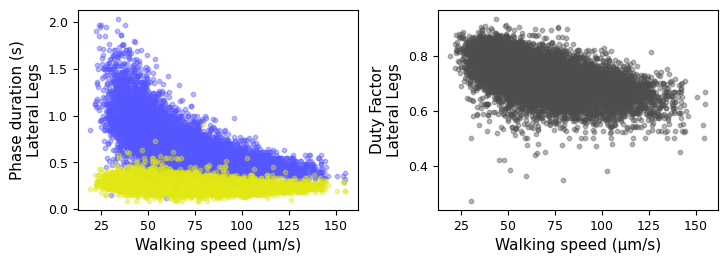

In [4]:
def stanceSwingPlot(ax,df,legs):
    df = df.copy()
    
    # only include lateral legs
    df = df[df['legID'].isin(legs)]

    if 'L4' in legs:
        leglab = 'Rear'
    else:
        leglab = 'Lateral'
    
    # grab data we need
    speed_during_steps_scaled = df['speed_during_step_scaled'].values * 1000
    stance_durations = df['stance'].values
    swing_durations = df['swing'].values
       
    # Stance and Swing Plot
    ax.scatter(speed_during_steps_scaled,stance_durations,c=stance_color,s=marker_size,alpha=marker_alpha)
    ax.scatter(speed_during_steps_scaled,swing_durations,c=swing_color,s=marker_size,alpha=marker_alpha)
    ax.set_ylabel('Phase duration (s)\n' + leglab + ' Legs', fontsize = axis_fontsize)
    ax.set_xlabel('Walking speed (µm/s)', fontsize = axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    print('n = ', len(speed_during_steps_scaled), 'strides are shown')

    r,p = stats.spearmanr(speed_during_steps_scaled,swing_durations)
    print('Swing: ρ =', np.round(r,2), 'p =', np.round(p,2))

    r,p = stats.spearmanr(speed_during_steps_scaled,stance_durations)
    print('Stance: ρ =', np.round(r,2), 'p =', np.round(p,2))
    
    return ax

def dutyFactorPlot(ax,df,legs):
    # Duty Factor Plot
    df = df[df['legID'].isin(legs)]
    if 'L4' in legs:
        leglab = 'Rear'
    else:
        leglab = 'Lateral'
    speed_during_steps_scaled = df['speed_during_step_scaled'].values * 1000
    duty_factor = df['duty'].values
    ax.scatter(speed_during_steps_scaled,duty_factor,c=duty_color,s=marker_size,alpha=marker_alpha)
    ax.set_ylabel('Duty Factor\n' + leglab + ' Legs', fontsize = axis_fontsize)
    ax.set_xlabel('Walking speed (µm/s)', fontsize = axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    r,p = stats.spearmanr(speed_during_steps_scaled,duty_factor)
    print('Duty Factor: ρ =', np.round(r,2), 'p =', np.round(p,2))
    return ax

legs = ['L3','L2','L1','R1','R2','R3']
f = plt.figure(figsize=(8,2.5))
ax1 = f.add_axes([0.1,0.1,0.35,0.8])
ax2 = f.add_axes([0.55,0.1,0.35,0.8])
ax1 = stanceSwingPlot(ax1,step_df,legs)
ax2 = dutyFactorPlot(ax2,step_df,legs)

for ax in [ax1,ax2]:
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.set_tick_params(labelsize=tick_fontsize)
    ax.yaxis.set_tick_params(labelsize=tick_fontsize)

plt.show()

### Rear Legs: walking speed vs. 1. stance and swing duration and 2. Duty Factor

n =  3692 strides are shown
Swing: ρ = -0.17 p = 0.0
Stance: ρ = -0.71 p = 0.0
Duty Factor: ρ = -0.58 p = 0.0


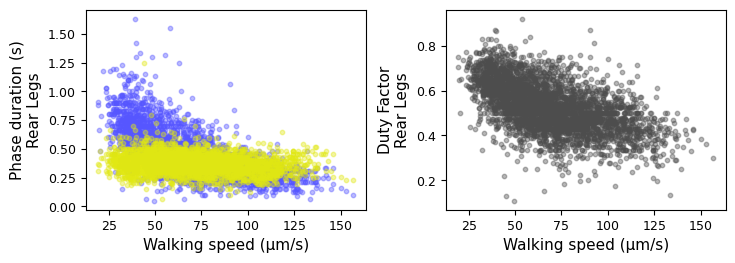

In [5]:
f = plt.figure(figsize=(8,2.5))
legs = ['L4','R4']
ax1 = f.add_axes([0.1,0.1,0.35,0.8])
ax2 = f.add_axes([0.55,0.1,0.35,0.8])
ax1 = stanceSwingPlot(ax1,step_df,legs)
ax2 = dutyFactorPlot(ax2,step_df,legs)

for ax in [ax1,ax2]:
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.set_tick_params(labelsize=tick_fontsize)
    ax.yaxis.set_tick_params(labelsize=tick_fontsize)

plt.show()

In [6]:
# Speed vs. step kinematic parameters for ALL STEPS
# by LEG PAIR 
def scatterCurve(ax,df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab,order=2,linewidth=1,alpha=0.05):
    
    for j, leg_pair in enumerate(leg_pairs):
        
        # get data for this pair for this datatype
        pair_data = df.copy()[df['legID'].isin(leg_pair)]
        print(' '.join(leg_pair), ': ', len(pair_data))
        
        pair_data[speed_col] = pair_data[speed_col].values * 1000 # convert to µm
     
        # scatter plot and regression line from seaborn
        sns.regplot(data=pair_data, x=xcol, y=ycol, ax=ax, line_kws={'linewidth':linewidth}, ci=None,
                    scatter_kws ={'s':3,'alpha':alpha}, color=pair_colors[j], order=order)
        
        if order == 1: # linear
            r,p = stats.spearmanr(pair_data[xcol].values, pair_data[ycol].values)
            print('for ' + xlab + ' vs. ' + ylab + ' in ' + ' '.join(leg_pair))
            print('   ... ρ =', np.round(r,2), 'p =', np.round(p,5))
    
    ax.xaxis.label.set_text(xlab)
    ax.yaxis.label.set_text(ylab)
    print()
    
    return ax

# add leg labels to an axis
def addLegLabs(ax, ytext=1.8, yinc=0.2, xtext=90, fontsize=14):
    # klugey legend
    leg_labs = ['first','second', 'third','rear']
    for i, leg_lab in enumerate(leg_labs):
        ax.text(xtext,ytext,fontsize=fontsize,color=pair_colors[i],s=leg_lab)
        ytext -= yinc
    return ax

# per-individual standard deviation in step kinematic parameters for each leg
def sdPlot(ax, df, parameter, parameter_label, binwidth, leg_pairs, pair_labels, pair_colors, linewidth=2):

    # get unique individuals
    individuals = np.sort(np.unique(df.uniq_id.values))
    
    # for each leg pair
    for j,leg_pair in enumerate(leg_pairs):

        leg_pair_data = df[df['legID'].isin(leg_pair)]
        
        # make empty list for std
        std_vals = []

        # for each individual
        for individual in individuals:
            
            individual_data = leg_pair_data[leg_pair_data['uniq_id']==individual][parameter].values
            
            if parameter == 'distance_during_step_scaled':
                individual_data = individual_data * 1000 # convert mm to µm
        
            # calculate std for parameter, and add to empty list
            std_for_parameter = np.nanstd(individual_data)
            std_vals.append(std_for_parameter)

        # done collecting data for parameter and leg pair ... convert list to numpy array and add to plot
        std_vals = np.array(std_vals)
#         print(len(std_vals)) # should be same as # of individuals ... yes OK
        
#         ax = sns.histplot(std_vals, ax=ax, binwidth=binwidth, kde=True, stat='probability',
#                  color=pair_colors[j],edgecolor='w',visible=True) # can set to false to hide bars
        
        ax = sns.kdeplot(std_vals, ax=ax, color=pair_colors[j], linewidth=linewidth, fill=True)
#         print(std_vals)
        
        ax.set_xlabel(parameter_label)
        
    return ax


In [7]:
print(step_df.columns)
step_df.head(3)

Index(['legID', 'DownTime', 'UpTime', 'stance', 'swing', 'gait', 'duty',
       'midSwingTime', 'L1_mid_swings', 'R1_mid_swings', 'L2_mid_swings',
       'R2_mid_swings', 'L3_mid_swings', 'R3_mid_swings', 'L4_mid_swings',
       'R4_mid_swings', 'anterior_swing_start', 'contralateral_swing_start',
       'speed_during_step', 'speed_during_step_scaled', 'distance_during_step',
       'distance_during_step_scaled', 'cruising_during_step',
       'average_tardigrade_area', 'average_tardigrade_length',
       'anterior_offsets', 'contralateral_offsets', 'metachronal_lag',
       'mcl_LR_ratio', 'L3_bearing_change', 'clip', 'treatment', 'individual',
       'date', 'uniq_id'],
      dtype='object')


,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,anterior_offsets,contralateral_offsets,metachronal_lag,mcl_LR_ratio,L3_bearing_change,clip,treatment,individual,date,uniq_id
0,L1,0.575,1.030,0.455,0.182,0.637,0.7143,1.1210,L1:0.8571,R1:0.4286,...,NaN,0.394,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
1,L1,1.212,1.848,0.636,0.182,0.818,0.7775,1.9390,L1:0.8888,R1:0.3888,...,NaN,0.394,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
2,L1,2.030,2.666,0.636,0.273,0.909,0.6997,2.8025,L1:0.8498,R1:0.3333,...,NaN,0.364,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris


In [8]:
# Per-individual Speed vs. step kinematic parameters (averages)
# by LEG PAIR 
def getIndividualParameters(df,parameter,leg_pairs):

    # parameters are stance, swing, gait, duty
    
    # for a given kinematic parameter, want 8 vectors, each with length as number of individuals:
    # speeds for each leg: average speed for individuals (in µm / s = 'speed_during_step_scaled') 
    # ... or body length?? = would need to divide by 'average_tardigrade_length'
    # first, second, third, fourth = average value for parameter
    
    # use these vectors to build a pandas dataframe, and use the dataframe to make a plot via seaborn
    
    # get unique individuals
    individuals = np.sort(np.unique(df.uniq_id.values))
    num_individuals = len(individuals)
    
    # build empty arrays
    leg_speeds = np.zeros([num_individuals,4])
    leg_parameter_vals = np.zeros([num_individuals,4])
    
    # go through individuals
    for i, individual in enumerate(individuals):
        ind_df = df[df.uniq_id == individual]
        
        # go through leg pairs
        for j, leg_pair in enumerate(leg_pairs):
        
            # get average speed for this leg pair
            leg_df = ind_df[ind_df['legID'].isin(leg_pair)]

            avg_speed = np.mean(leg_df['speed_during_step_scaled'].values) * 1000
        
            # here is where I could normalize to body length
            avg_length = np.mean(leg_df['speed_during_step_scaled'].values)
#             avg_speed = avg_speed / avg_length
            
            # add speed to vector at position i    
            leg_speeds[i,j] = avg_speed
#             print(individual, leg_pair, j, i, avg_speed, leg_speeds[j][i]) # testing OK
            
            # get average parameter for this leg pair, add to vector at position i
            avg_parameter = np.mean(leg_df[parameter].values)
            leg_parameter_vals[i,j] = avg_parameter
#             print(individual, leg_pair, j, i, avg_parameter, leg_parameter_vals[j][i]) # testing OK
    
    # have data we need ... build a pandas dataframe
    # 1. make column names
    col_names = []
    leg_labs = ['first','second','third','rear']
    for lab in leg_labs:
        col_names.append(lab + '_speed')
    for lab in leg_labs:
        col_names.append(lab + '_' + parameter)
    
    # 2. build a dictionary of names:values
    speed_vals = [leg_speeds[:,x] for x in np.arange(4)]
    parameter_vals = [leg_parameter_vals[:,x] for x in np.arange(4)]
    all_vals = speed_vals + parameter_vals
    
    parameter_dict = dict(zip(col_names,all_vals))
    
    # 3. convert dictionary to dataframe
    parameter_df = pd.DataFrame(parameter_dict)
    
    return parameter_df

# load gait data from step_timing sheet
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
leg_pairs = [['L1','R1'],['L2','R2'],['L3','R3'],['L4','R4']]
parameters = ['stance','swing','gait','duty']

p_df = getIndividualParameters(step_df,parameters[0],leg_pairs)
p_df.head(3)

,first_speed,second_speed,third_speed,rear_speed,first_stance,second_stance,third_stance,rear_stance
0,72.759616,74.696534,74.345533,72.698450,0.751095,0.695300,0.833000,0.609619
1,41.248066,41.572353,42.946971,41.547448,1.025733,1.139000,1.015133,0.587333
2,100.115989,100.658769,100.089050,98.825200,0.482767,0.461517,0.447267,0.233644


In [9]:
def scatterIndividual(ax,df,parameter,leg_pairs,pair_colors,xlab,ylab,order=1,linewidth=2,alpha=0.3):
    leg_labs = ['first','second','third','rear']
    p_df = getIndividualParameters(step_df,parameter,leg_pairs)
    for i,pair in enumerate(leg_labs):
        xcol = pair + '_speed'
        ycol = pair + '_' + parameter

        sns.regplot(data=p_df, x=xcol, y=ycol, ax=ax, line_kws={'linewidth':linewidth}, ci=None,
                            scatter_kws ={'s':3,'alpha':alpha}, color=pair_colors[i], order=order)
    
        if order == 1: # linear
            r,p = stats.spearmanr(p_df[xcol].values, p_df[ycol].values)
            print('for ' + xlab + ' vs. ' + ylab + ' in ' + ' '.join(leg_pairs[i]))
            print('   ... ρ =', np.round(r,2), 'p =', np.round(p,5))
    
    ax.xaxis.label.set_text(xlab)
    ax.yaxis.label.set_text(ylab)
    return ax

for Walking Speed (µm/s) vs. Duty Factor in L1 R1
   ... ρ = -0.8 p = 0.0
for Walking Speed (µm/s) vs. Duty Factor in L2 R2
   ... ρ = -0.74 p = 0.0
for Walking Speed (µm/s) vs. Duty Factor in L3 R3
   ... ρ = -0.67 p = 0.0
for Walking Speed (µm/s) vs. Duty Factor in L4 R4
   ... ρ = -0.65 p = 0.0


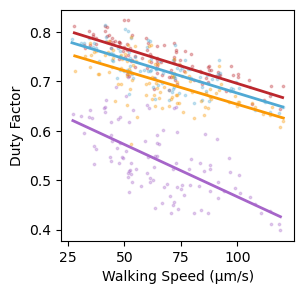

In [13]:
parameters = ['stance','swing','duty','gait']
par_index = 2

# load gait data from step_timing sheet
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
leg_pairs = [['L1','R1'],['L2','R2'],['L3','R3'],['L4','R4']]
pair_colors = [first_pair_color, second_pair_color, third_pair_color, rear_pair_color]

ylabs = ['Stance\nDuration (s)','Swing\nDuration (s)','Duty Factor','Period (s)']
xlab='Walking Speed (µm/s)'

orders = [2,1,1,2]

parameter = parameters[par_index]

f,ax = plt.subplots(1,1,figsize=(3,3))

ax = scatterIndividual(ax,step_df,parameter,leg_pairs,pair_colors,xlab,ylabs[par_index],
                       order=orders[par_index],linewidth=2,alpha=0.3)
    
plt.show()

# Figure 3

for Walking Speed (µm/s) vs. Swing
Duration (s) in L1 R1
   ... ρ = -0.5 p = 0.0
for Walking Speed (µm/s) vs. Swing
Duration (s) in L2 R2
   ... ρ = -0.57 p = 0.0
for Walking Speed (µm/s) vs. Swing
Duration (s) in L3 R3
   ... ρ = -0.6 p = 0.0
for Walking Speed (µm/s) vs. Swing
Duration (s) in L4 R4
   ... ρ = -0.32 p = 0.00104
for Walking Speed (µm/s) vs. Duty Factor in L1 R1
   ... ρ = -0.8 p = 0.0
for Walking Speed (µm/s) vs. Duty Factor in L2 R2
   ... ρ = -0.74 p = 0.0
for Walking Speed (µm/s) vs. Duty Factor in L3 R3
   ... ρ = -0.67 p = 0.0
for Walking Speed (µm/s) vs. Duty Factor in L4 R4
   ... ρ = -0.65 p = 0.0


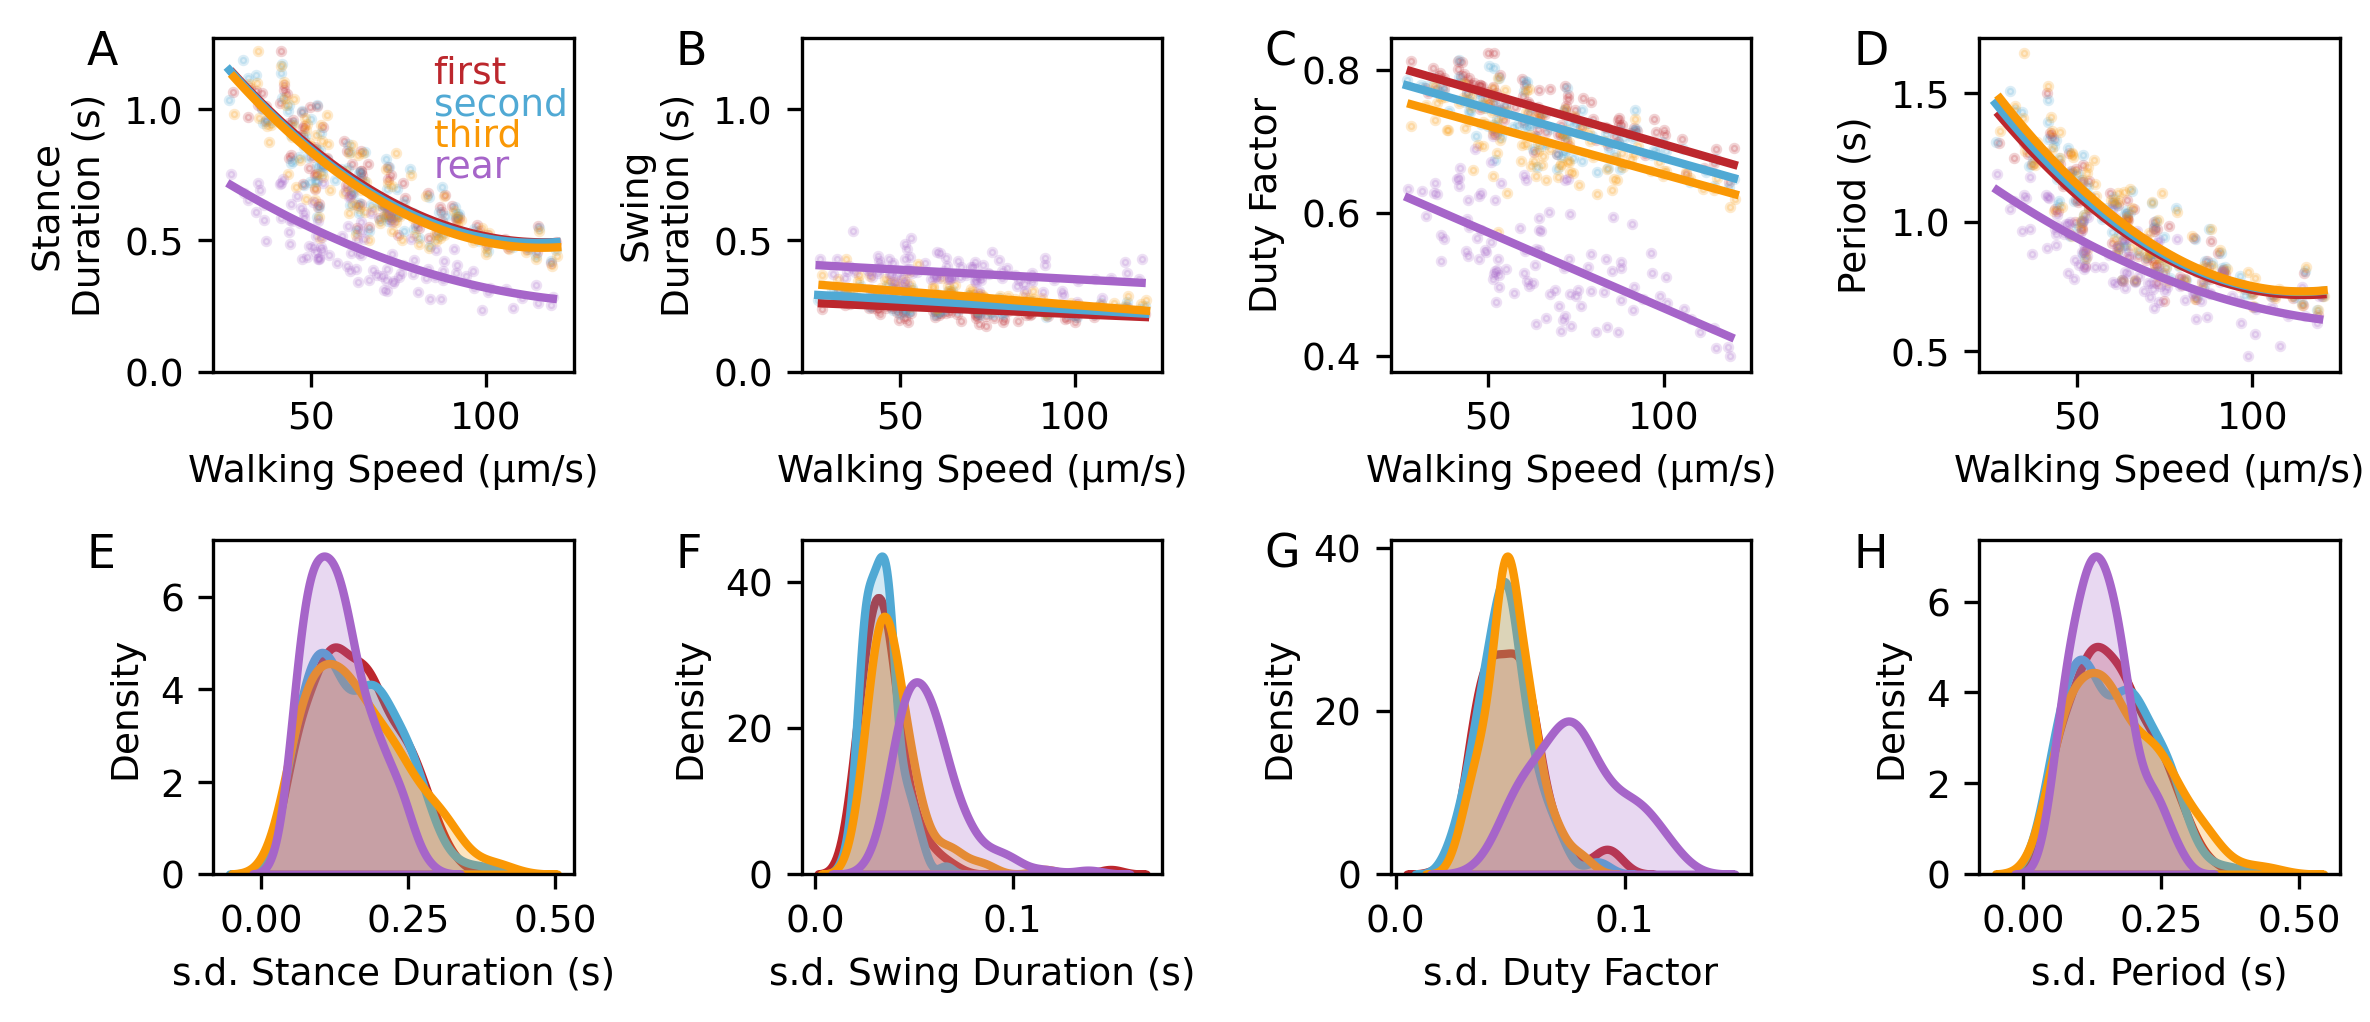

In [14]:
# Figure 3

# Scatter type can be by 'steps' or by 'individuals'
scatter_type = 'ind'

f,axes = plt.subplots(2, 4, figsize=(8,3.5), dpi=300)
axes_list = axes.flatten()

if scatter_type == 'steps':
    alpha_scatter = 0.02
else:
    alpha_scatter = 0.2
    
scatter_linewidth=2

# load gait data from step_timing sheet
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)

leg_pairs = [['L1','R1'],['L2','R2'],['L3','R3'],['L4','R4']]
pair_labels = ['first','second','third','rear']
pair_colors = [first_pair_color, second_pair_color, third_pair_color, rear_pair_color]
speed_col = 'speed_during_step_scaled'

#### scatter plots

# stance for all steps of each leg pair
xcol='speed_during_step_scaled'
xlab='Walking Speed (µm/s)'
ycol='stance'
ylab='Stance\nDuration (s)'
order=2
if scatter_type == 'steps':
    axes_list[0] = scatterCurve(axes_list[0],step_df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab, 
                                order=order, linewidth=scatter_linewidth, alpha=alpha_scatter)
    axes_list[0] = addLegLabs(axes_list[0], fontsize=tick_fontsize, yinc=0.25, xtext=85, ytext=1.85)
else:
    axes_list[0] = scatterIndividual(axes_list[0],step_df,ycol,leg_pairs,pair_colors,xlab,ylab,
                                     order=order,linewidth=scatter_linewidth,alpha=alpha_scatter)
    axes_list[0] = addLegLabs(axes_list[0], fontsize=tick_fontsize, yinc=0.12, xtext=85, ytext=1.1)
    ymin,ymax = axes_list[0].get_ylim()
    ylim = (0, ymax)
    axes_list[0].set_ylim(ylim)
       

# swing for all steps of each leg pair
ycol='swing'
ylab='Swing\nDuration (s)'
order=1
if scatter_type == 'steps':
    axes_list[1] = scatterCurve(axes_list[1],step_df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab, 
                                order=order, linewidth=scatter_linewidth, alpha=alpha_scatter)
else:
    axes_list[1] = scatterIndividual(axes_list[1],step_df,ycol,leg_pairs,pair_colors,xlab,ylab, 
                                     order=order,linewidth=scatter_linewidth,alpha=alpha_scatter)
    
ylim = axes_list[0].get_ylim()
axes_list[1].set_ylim(ylim)

# duty factor for all steps of each leg pair
ycol='duty'
ylab='Duty Factor'
order=1
if scatter_type == 'steps':
    axes_list[2] = scatterCurve(axes_list[2],step_df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab, 
                                order=order, linewidth=scatter_linewidth, alpha=alpha_scatter)
else:
    axes_list[2] = scatterIndividual(axes_list[2],step_df,ycol,leg_pairs,pair_colors,xlab,ylab, 
                                     order=order,linewidth=scatter_linewidth,alpha=alpha_scatter)

# Step Period for all steps of each leg pair
ycol='gait'
ylab='Period (s)'
order=2
if scatter_type == 'steps':
    axes_list[3] = scatterCurve(axes_list[3],step_df,leg_pairs,pair_colors,xcol,ycol,xlab,ylab, 
                                order=order, linewidth=scatter_linewidth, alpha=alpha_scatter)
else:
    axes_list[3] = scatterIndividual(axes_list[3],step_df,ycol,leg_pairs,pair_colors,xlab,ylab, 
                                     order=order,linewidth=scatter_linewidth,alpha=alpha_scatter)


#### standard deviation plots

parameters = ['stance','swing','duty','gait']
parameter_labels = ['s.d. Stance Duration (s)','s.d. Swing Duration (s)','s.d. Duty Factor',
                    's.d. Period (s)']
binwidths = np.array([ 0.04, 0.01, 0.01, 0.04])
binwidths *= 0.8

for i, ax in enumerate(axes_list[4:]):
    ax = sdPlot(ax, step_df, parameters[i], parameter_labels[i], binwidths[i], 
                leg_pairs, pair_labels, pair_colors, linewidth=scatter_linewidth)

    
    
#### add call outs
letters = ['A','B','C','D','E','F','G','H']
for i, ax in enumerate(axes_list):
    ax.annotate(letters[i], xy=(-0.35, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.set_tick_params(labelsize=tick_fontsize)
    ax.yaxis.set_tick_params(labelsize=tick_fontsize)
    if i <= 3 and scatter_type == 'steps':
        ax.set_xlim([25,135])

plt.tight_layout()
plt.show()

# Data table for step kinematics

In [15]:
# get offsets for step kinematics table
first_pair = ['L1','R1']
second_pair = ['L2','R2']
third_pair = ['L3','R3']
fourth_pair = ['L4','R4']
rear_legs = fourth_pair
lateral_legs = third_pair + second_pair + first_pair
ipsi_offset_legs = third_pair + second_pair
left_laterals = [x[0] for x in [third_pair, second_pair, first_pair]]
right_laterals = [x[1] for x in [third_pair, second_pair, first_pair]]
all_legs = rear_legs + lateral_legs
left_legs = [x[0] for x in [fourth_pair, third_pair, second_pair, first_pair]]
right_legs = [x[1] for x in [fourth_pair, third_pair, second_pair, first_pair]]
single_leg = ['R4']

# dictionaries of inter-leg relationships
ipsi_legs = {'L4':'L3','R4':'R3','L3':'L2','L2':'L1','R3':'R2','R2':'R1'}
contra_legs = {'L4':'R4','R4':'L4','L3':'R3','L2':'R2','R3':'L3','R2':'L2','L1':'R1','R1':'L1'}

Total number of gait cycles analyzed:  13163
Lateral Gait cycles:  9471
Rear Gait cycles:     3692
Number of individuals analyzed:   103


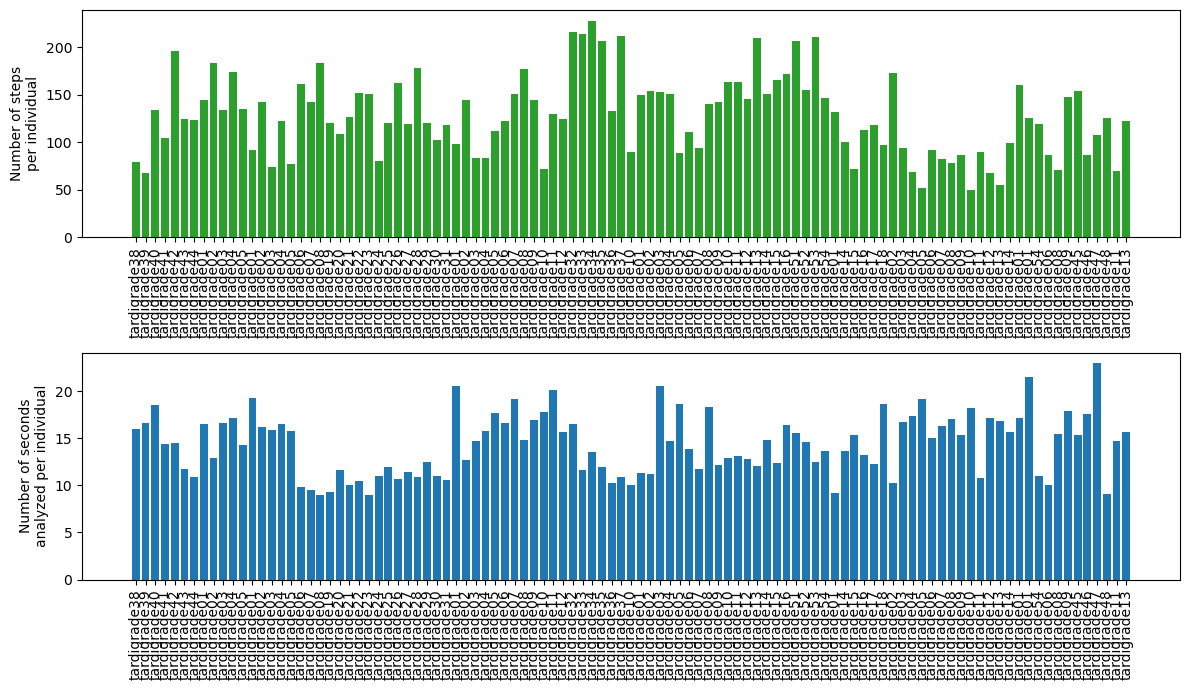

In [16]:
# report number of steps and time analyzed per individual
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
print('Total number of gait cycles analyzed: ', len(step_df))
print('Lateral Gait cycles: ', len(step_df[step_df['legID'].isin(['L3','L2','L1','R3','R2','R1'])]))
print('Rear Gait cycles:    ', len(step_df[step_df['legID'].isin(['L4','R4'])]))
f,(a1,a2) = plt.subplots(2,1,figsize=(12,7))
steps_analyzed = {} # key = unique id, value = # steps analyzed
individuals = np.sort(np.unique(step_df['uniq_id'].values))
print('Number of individuals analyzed:  ', len(individuals))
for i, individual in enumerate(individuals):
    steps_for_individual = len(step_df[step_df['uniq_id']==individual])
    steps_analyzed[individual] = steps_for_individual
    a1.bar(i, steps_for_individual, color = 'tab:green')
a1.set_ylabel('Number of steps\nper individual')
a1.set_xticks(np.arange(0,len(individuals)))
a1.set_xticklabels([x.split('_')[2] for x in individuals], rotation=90)

# report total time collecting step data per individual
# load data from gait_styles sheet
fps = 33
gait_df = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
secs_analyzed = dict(zip(individuals,gait_df['Number of frames'].values / fps))
for i, individual in enumerate(individuals):
    a2.bar(i, secs_analyzed[individual], color = 'tab:blue')
a2.set_ylabel('Number of seconds\nanalyzed per individual')
a2.set_xticks(np.arange(0,len(individuals)))
a2.set_xticklabels([x.split('_')[2] for x in individuals], rotation=90)
plt.tight_layout()
plt.show()

### Compare to Nirody values

In [17]:
''' 
NIRODY Table S2 Values:
'Number of animals': [23,20],
'Body length (μm)':['338.12 ± 45.04','364.53 ± 44.09'],
'Walking speed (μm/s)':['160.50 ± 57.79','91.0 ± 32.0'],
'Step length (μm)': ['90.52 ± 23.70','82.07 ± 19.74'],
'Period (s)': ['0.82 ± 0.24','1.27 ± 0.41'],
'Stance duration (s)': ['0.57 ± 0.21','0.97 ± 0.37'],
'Swing duration (s)': ['0.25 ± 0.08','0.30 ± 0.09'],
'Duty Factor (%)': ['0.68 ± 0.08','0.75 ± 0.07']
'''

row_names = ['Number of animals',
             'Body length (μm)',
             'Walking speed (μm/s)',
             'Speed (length/s)',
             'Step length (μm)',
             'Period (s)',
             'Stance duration (s)',
             'Swing duraction (s)',
             'Duty Factor (%)',
            ]

nirody_50pa = ['23','338.12 ± 45.04','160.50 ± 57.79',str(np.round(160.5/338.12,2)),'90.52 ± 23.70',
              '0.82 ± 0.24','0.57 ± 0.21','0.25 ± 0.08','0.68 ± 0.08']

nirody_10pa = ['20','364.53 ± 44.09','91.0 ± 32.0',str(np.round(91/364.53,2)),'82.07 ± 19.74',
              '1.27 ± 0.41','0.97 ± 0.37','0.30 ± 0.09','0.75 ± 0.07']

colname = 'Woodslab'

# load the path summaries data into a dataframe (this has size and speed data)
path_df = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)

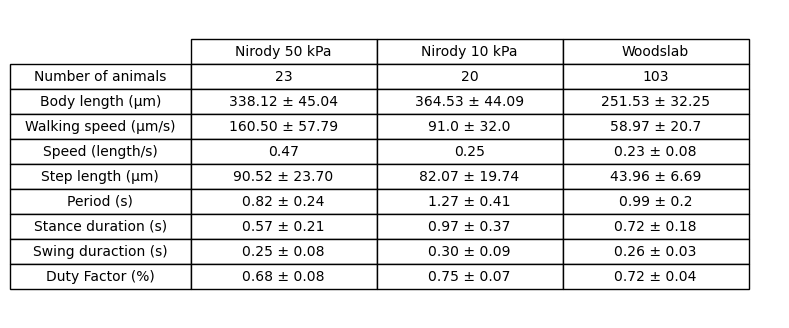

In [18]:
number_animals = str(len(path_df.individual.values))
body_length = meanstdstr(path_df['Body Length (mm)'].values * 1000)
speed_scaled = meanstdstr(path_df['Speed (mm/sec)'].values * 1000) # sec or sec cruising
speed_normalized = meanstdstr(path_df['Speed (body lengths / sec)'].values) # sec or sec cruising
# speed_scaled = meanstdstr(path_df['Speed (mm/sec cruising)'].values * 1000) # sec or sec cruising
# speed_normalized = meanstdstr(path_df['Speed (body lengths / sec cruising)'].values) # sec or sec cruising

# load the step_summaries data into a dataframe (this has step kinematics data)
step_summaries_df = pd.read_excel(excel_file, sheet_name='step_summaries', index_col=None)
step_length = meanstdstr(step_summaries_df['mm per step (lateral legs)'].values * 1000)
period = meanstdstr(step_summaries_df['Gait cycle (lateral legs)'].values)
stance_duration = meanstdstr(step_summaries_df['Stance duration (lateral legs)'].values)
swing_duration = meanstdstr(step_summaries_df['Swing duration (lateral legs)'].values)
duty_factor = meanstdstr(step_summaries_df['Duty factor (lateral legs)'].values)

col_data = [number_animals, body_length, speed_scaled, speed_normalized, step_length,
           period, stance_duration, swing_duration, duty_factor]

table_vals = np.column_stack([nirody_50pa,nirody_10pa,col_data])
col_labels = ['Nirody 50 kPa','Nirody 10 kPa', colname]
row_labels = row_names
row_colors = ['white'] * len(row_labels)
col_colors = ['white'] * len(col_labels)

plt.figure(figsize=(8,4))
ax = plt.gca()

my_table = plt.table(cellText=table_vals,
                     colWidths=[0.3] * len(col_labels),
                     rowLabels=row_labels,
                     rowLoc='center', # left, center, right
                     cellLoc='center',
                     colLoc='center',
                     colLabels=col_labels,
#                      cellColours=cell_colors,
                     rowColours=row_colors,
                     colColours=col_colors,
#                      edges='horizontal',
                     loc='center')
my_table.scale(1, 1.5) # increase vertical space
ax.set_axis_off()
plt.show()

In [19]:
# add seconds analyzed and steps analyzed
step_summaries_df.sort_values(by='Identifier',inplace=True)
secs = [secs_analyzed[x] for x in step_summaries_df['Identifier'].values]
steps = [steps_analyzed[x] for x in step_summaries_df['Identifier'].values]
step_summaries_df['Steps Analyzed'] = steps
step_summaries_df['Seconds Analyzed'] = secs

In [20]:
print('Steps Analyzed: ' + meanstdstr(step_summaries_df['Steps Analyzed'].values))
print('Seconds Analyzed: ' + meanstdstr(step_summaries_df['Seconds Analyzed'].values))
print('Metachronal lag Left-Right Ratio: ' + meanstdstr(step_summaries_df['Metachronal lag Abs (Left-Right Ratio)'].values))

Steps Analyzed: 127.8 ± 41.49
Seconds Analyzed: 14.37 ± 3.21
Metachronal lag Left-Right Ratio: 0.32 ± 0.23


In [21]:
'''
compile data for violin plots
'''

mcl_ratio_dict = {} # dictionary of mean MCL ratios / L3 step, keyed by individual
abs_mcl_ratio_dict = {} # dictionary of mean abs (ratios) / L3 step, keyed by individual
bearing_change_l3_dict = {} # dictionary of sum (abs (bearing changes per L3 step)), keyed by individual
bearing_persec_dict = {} # dictionary of sum (abs (bearing changes per L3 step)) / steptracking_secs, keyed by individual

individuals = np.sort(np.unique(step_df['uniq_id'].values))
for individual in individuals:
    # get data for individual
    ind_data = step_df[step_df['uniq_id']==individual]
    mcl_ratios = gaitFunctions.omitNan(ind_data['mcl_LR_ratio'].values)
    l3_bearings = gaitFunctions.omitNan(ind_data['L3_bearing_change'].values)

    # get steptracking time from step_summaries_df
    secs_analyzed = step_summaries_df[step_summaries_df.Identifier == individual]['Seconds Analyzed'].values[0]
 
    # add data to dictionaries
    mcl_ratio_dict[individual] = np.mean(mcl_ratios)
    abs_mcl_ratio_dict[individual] = np.mean(np.abs(mcl_ratios))
    bearing_change_l3_dict[individual] = np.sum(np.abs(l3_bearings))
    bearing_persec_dict[individual] = np.sum(np.abs(l3_bearings))/secs_analyzed

individuals = step_summaries_df.Identifier.values
mcl_ratio_col = [mcl_ratio_dict[i] for i in individuals]
abs_mcl_ratio_col = [abs_mcl_ratio_dict[i] for i in individuals]
bearing_change_l3_col = [bearing_change_l3_dict[i] for i in individuals]
bearing_persec_col = [bearing_persec_dict[i] for i in individuals]

step_summaries_df['MCL Ratio per L3'] = mcl_ratio_col
step_summaries_df['Abs MCL Ratio per L3'] = abs_mcl_ratio_col
step_summaries_df['Total Bearing Change per L3'] = bearing_change_l3_col
step_summaries_df['L3 Bearing Change / sec steptracking'] = bearing_persec_col

In [22]:
columns_to_analyze = [
    'Steps Analyzed', #   1
    'Seconds Analyzed', # 2
    'Stance duration (lateral legs)', 
    'Stance duration (rear legs)',
    'Swing duration (lateral legs)',
    'Swing duration (rear legs)',
    'Gait cycle (lateral legs)', 
    'Gait cycle (rear legs)',
    'Duty factor (lateral legs)',
    'Duty factor (rear legs)',
#     'mm per step (lateral legs)', 
#     'mm per step (rear legs)',
    'bodylength per step (lateral legs)',
    'bodylength per step (rear legs)',   
    'Metachronal lag (lateral legs)',
    'Metachronal lag (normalized, lateral legs)',
#        'Metachronal lag Abs (Left-Right Ratio)', # 'old way'
    'Metachronal lag ratios per L3 step', 
    'Abs MCL Ratio per L3',
    'L3 Bearing Change / sec steptracking',
#     'Bearing change per L3 step',
#     'Anterior swing offsets (lateral legs)',
    'Anterior swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (lateral legs)',
    'Opposite swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (rear legs)',
    'Opposite swing offsets (normalized, rear legs)'
#     'MCL Ratio per L3', 
#     'Total Bearing Change per L3' 
]

column_labels = [
    'Steps Analyzed',
    'Seconds Analyzed',
    'Stance duration - lateral\n(sec)', 
    'Stance duration - rear\n(sec)', 
    'Swing duration - lateral\n(sec)',
    'Swing duration - rear\n(sec)',
    'Period - lateral\n(sec)', 
    'Period - rear\n(sec)', 
    'Duty factor - lateral',
    'Duty factor - rear',
#     'Distance / step - lateral\n(mm)', 
#     'Distance / step - rear\n(mm)', 
    'Body Length / step\nlateral',
    'Body Length / step\nrear',
    'Metachronal lag (sec)',
    'Metachronal lag / Period',
    'Metachronal lag\nLog2 Ratio',
    'Abs Metachronal lag\nLog2 Ratio',
    'Bearing Change\n(˚/sec step tracking)',
    #'Anterior swing offsets (lateral legs)',
    '$ϕ_I$ (lateral legs)',
    #'Opposite swing offsets (lateral legs)',
    '$ϕ_C$ (lateral legs)',
    #'Opposite swing offsets (rear legs)',
    '$ϕ_C$ (rear legs)' 
]
print(len(columns_to_analyze), len(column_labels))

20 20


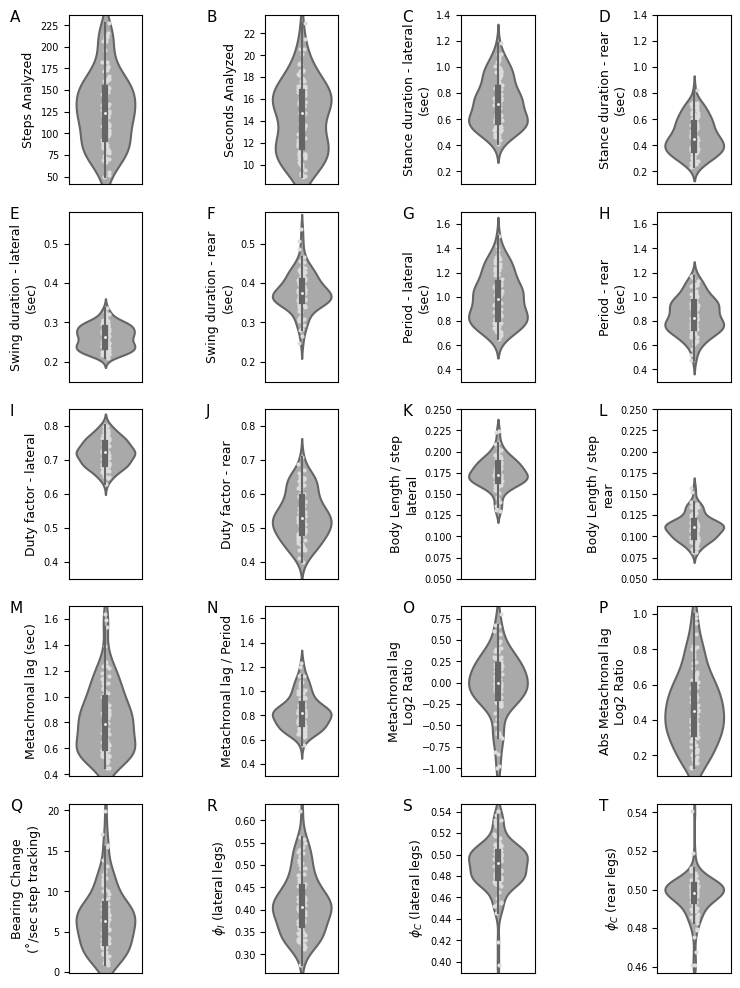

In [23]:
rows,cols = [5,4]
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
f,axes = plt.subplots(rows,cols,figsize = (8,10))
axes_list = axes.reshape(1,len(columns_to_analyze))[0]
for i, col in enumerate(columns_to_analyze):
    axes_list[i] = gaitFunctions.singleViolinPoints(axes_list[i], step_summaries_df, col, box=True,
                                                   pointcolor='gainsboro',vcolor='darkgray')
    axes_list[i].yaxis.label.set_text(column_labels[i])
    axes_list[i].yaxis.label.set_size(tick_fontsize)
    axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize-2)
    
    if 'Stance' in column_labels[i]:
        axes_list[i].set_ylim([0.1, 1.4])
    if 'Swing' in column_labels[i]:
        axes_list[i].set_ylim([0.15, 0.58])
    if 'Period' in column_labels[i]:
        axes_list[i].set_ylim([0.3, 1.7])
    if 'Duty' in column_labels[i]:
        axes_list[i].set_ylim([0.35, 0.85])
    if 'Body Length' in column_labels[i]:
        axes_list[i].set_ylim([0.05, 0.25])
    if 'offset' in column_labels[i]:
        axes_list[i].set_ylim([0.25, 0.7])
        
    axes_list[i].annotate(letters[i], xy=(-0.8, 0.96), xycoords='axes fraction', fontsize=axis_fontsize)
    

plt.tight_layout()
plt.show()

In [ ]:
# # can also save as an excel file ... 
# out_file = 'step_kinematic_measurements.xlsx'
# with pd.ExcelWriter(out_file, engine='openpyxl') as writer: 
#     summary_df[['Measurement','Mean ± Std']].to_excel(writer, index=False, sheet_name='step kinematics')